# Sélection de caractéristiques

Comme nous l'avons vu en cours, les approches de machine-learning ne sont pas réellement capables de sélectionner les bonnes caractéristiques: il est donc essentiel de sélectionner les informations utiles et d'éliminer (au moins une part) de l'information inutile.

Ce notebook vise à reproduire l'essentiel des expéricences vues dans les transparents de cours: ce sont les exemples que nous trouvons les plus parlant pour mettre en évidence l'importance de cette tâche critique.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from outils.frontiere import *
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# données + dimensions inutiles
centers = [[-2.0, -2.0], [2.0, 2.0]]
clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=100, centers=centers, cluster_std=clusters_std,  n_features=2,   random_state=0) # 100 pts, 2classes, 2dim 

# ajout de bruit
ndim_noise = 20
Noise = np.random.randn(len(X), ndim_noise)*clusters_std[0]
Xn = np.concatenate((X,Noise), axis=1)

# split
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=0.33, random_state=0)

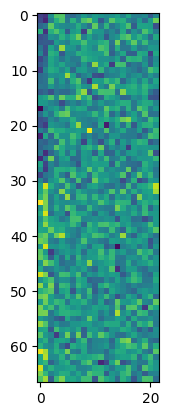

In [3]:
# visualisation des données complètes

ind = np.argsort(y_train)
plt.figure(facecolor='white')

plt.imshow(X_train[ind])
#plt.savefig("fig/Xbruit.png", bbox_inches='tight')

## A. Curse of dimensionality / fléau de la dimensionalité

1. Vérifier la dimension des données générées ci-dessus
2. Vérifier que vous pouvez afficher ce problème jouet en utilisant les deux premières dimension de `X_train`
3. Reproduction de l'expérience sur le fléau de la dimensionalité

<img src = "fig/curse.png">


In [4]:
# Dimension de X

# Scatter plot de X (deux première dimension)

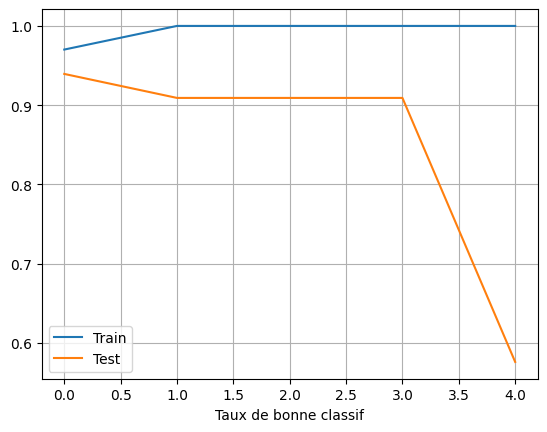

In [7]:
# reproduction de l'expérience sur le fléau de la dimensionalité
mod = svm.SVC(gamma = 0.1) # proposition de classifieur qui doit mettre en évidence le phénomène de sur-apprentissage
perf_train = []
perf_test  = []

# on commence par les données de base et on ajoute progressivement du bruit
for ndim in range(2,X_train.shape[1],4) : # Ajout des dimensions de bruit 4 par 4
    # 1.extraction des données temporaire
    # 2. apprentissage du modèle
    # 3. Evaluation et stockage (poour le tracé de la courbe)

    #  TODO 

# avec tous les résultats stockés dans:
# perf_train
# perf_test
plt.figure(facecolor='white')
plt.plot(perf_train)
plt.plot(perf_test)
plt.grid()
plt.xlabel("Itération")
plt.xlabel("Taux de bonne classif")
plt.legend(['Train', 'Test'])

## B. Réduction / sélection de dimensions

Les stratégies d'analyse des poids du classifieur linéaire et de *feature importance* sur les forêts aléatoires sont utiles... Mais elles ont été vues dans le dernier TP et ne sont pas reprise ici.


### B.0. Stratégies naïves, parfois très efficace

... Mais pas tout le temps

* Expérience naïve de corrélation entre les variables et $y$



In [ ]:
# calcul de correlation entre les variables et y

corr = np.abs(X_train.T @ y_train)
plt.figure()
plt.bar(np.arange(len(corr)), corr)

# ... Sur un exemple jouet, ça marche vraiment très bien ...
# A tester sur des exemples réels, on ne sait jamais, le critère est intéressant !

#plt.savefig("fig/corr_var.png")


## B.1. Stratégies implémentées dans scikit-learn

Nous allons voir quelques stratégies de réduction de la dimensionnalité:

* Elimination successive des dimensions les moins intéressantes (ou ajout des dimensions intéressante)
    * Avant toute chose: il faut un critère de sélection (ici, le taux de bonne classification d'un SVC)
    * doc: [lien](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html#sklearn.feature_selection.SequentialFeatureSelector)
    * Stratégie potentiellement **très couteuse**: il faut bien regarder les paramètres
        * Que penser de la différence entre *forward* et *backward*

* Point de vue syntaxique:
    * ```fit``` faire tous les calculs
    * ```transform``` appliquer la sélection de dimension sur X & Xtest (éliminer effectivement les dimensions non retenue)


In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

estimator = svm.SVC(kernel="linear") # je choisis d'utiliser le score en classif d'un SVM lineaire
selector = SequentialFeatureSelector(estimator, n_features_to_select=2) # le nombre de dimension à garder est spécifié... 
                                                                        # ... Pas très réaliste: en général, il faut tester!
selector = selector.fit(X_train, y_train) # calcul des dimensions à conserver

print(selector.get_support())

# il eset ensuite possible de filtrer les données:
Xnew = selector.transform(X_train) # application du filtre
print("Ancienne dimensions : ",X_train.shape)
print("Nouvelles dimensions : ",Xnew.shape)

In [ ]:
# impact en temps de calcul des options:
import time

# forward
t = time.time()
estimator = svm.SVC(kernel="linear")
selector = SequentialFeatureSelector(estimator, n_features_to_select=2)
selector = selector.fit(X_train, y_train)
print(selector.get_support())
print("durée: {}".format(time.time()-t))

# backward
# Ajouter la bonne option et lancer le chronomètre. 
# bien comprendre l'algorithme qui tourne derrière
###  TODO  ###

## B.2. ACP/PCA : Analyse en composantes principales

Trouver les combinaisons de variables qui permettent *d'expliquer les données*

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

* Ce critère, très efficace et très utilisé, n'est pas lié aux étiquettes $y$!
* dans ce critère, on peut analyser les valeurs propres pour choisir combien d'axes conserver

<img src="fig/valp.png">

* D'après la figure, une valeur propre (ou deux) sont suffisantes pour bien représenter les données...
    * Projeter les données dans cet espace
    * Apprendre un classifieur et comparer les performances par rapport à l'espace de représentation d'origine

<img src="fig/pca.png">

**Note:** Les performances sur 1 seule dimension sont quasi-optimales! <BR>
**Note 2:** Quand on prend tous les axes, on retrouve le piètre niveau de performance original (logique, l'information est la même) <BR>
**Notes 3:** Comment expliquer que les meilleures perfromances soient obtenues avec ```n_comp=8```?

In [ ]:
from sklearn.decomposition import PCA
# application de la PCA

pca = PCA() # on peut préciser le nombre de valeurs propres à
            # conserver /calculer: n_components=10
pca.fit(X_train)  # calcul des valeurs propres, vecteurs propres

# Analyse des valeurs propres:
plt.figure(facecolor='white', figsize=[8,4])
plt.subplot(1,2,1)
plt.bar(np.arange(X_train.shape[1]), pca.singular_values_)
plt.subplot(1,2,2)
plt.plot(pca.explained_variance_ratio_)
plt.grid()
#plt.savefig('fig/valp.png')


### B.2.1 Evolution des performances en fonction de la dimension

In [ ]:
# projection des données dans cet espace à un ou deux axes:
# + apprentissage de modele
# + evaluation des performances

Xnew = pca.transform(X_train) # projection sur tous les axes
XnewT = pca.transform(X_test) # projection sur tous les axes

# boucle for:
#   Xnew = proj sur 1, 2, 3, ... d vecteurs propres
#   Apprentissage modèle
#   Evaluation des performances
# => Conclusion: sur combien de dimension faut-il projeter?

###  TODO  ###

### B.2.2 Réduction en 2D = possibilité de visualisation

In [ ]:
# affichage de nuage de point projeté en 1D et 2D

# projeter les données en 1 ou 2 dimensions => capacité de visualisation

###  TODO  ###

### B.2.3 Application sur les données en grande dimension [séance dédiée un peu plus tard]

Peut-on utiliser la PCA sur les données USPS avec lesquelles nous avons joué il y a quelques semaines??

OUI! Evidemment.

* Idée 1: on va visualiser les données USPS en 2 dimensions!
* Idée 2: on va voir s'il est possible de classer les données USPS dans cet espace réduit

In [ ]:
# Chargement des données
import pickle as pkl
data = pkl.load(open("data/usps.pkl",'rb')) 
# data est un dictionnaire contenant les champs explicites X_train, X_test, Y_train, Y_test
X_train = np.array(data["X_train"],dtype=float) # changement de type pour éviter les problèmes d'affichage
X_test = np.array(data["X_test"],dtype=float)
Y_train = data["Y_train"]
Y_test = data["Y_test"]

# pour rappel sur la structuration des données: affichage de l'image 18 avec reshape
plt.figure()
plt.imshow(X_train[18].reshape(16,16),cmap="gray")
plt.title("Image de : {}".format(Y_train[18]))

# Faire la projection

# Affichage de la base projetée sur les deux premiers axes

# Afficher également les axes de projection eux-mêmes

# Calculer la performance en fonction du nombre d'axes utilisés

In [ ]:
###  TODO  ###

## B.3. Régularisation

La promesse : sélectionner les bonnes dimensions au cours de l'apprentissage. Nous avons vu les mécanismes dans la séance sur le gradient.

* Pénalisation extrême des poids => Aucune dimension retenue (= simplicité extrême)... Mais performances très faible.
* Pénalisation faible: retour à la situation initiale (bonne perf mais risque de sur-apprentissage)
* **Question:** quid des situations intermédiaires? Quel compromis entre parcimonie et performances?

Nous allons envisager plusieurs formulations, faire varier la régularisation et étudier à la fois la performance et la parcimonie. Comme indicateur de parcimonie, nous étudierons le pourcentage de $w$ non nul:

$$Parcimonie = \frac{\sum_j I_{w_j \ne 0}}{d}$$

### B.3.1. Régularisation L2

Nous avons déjà croisé la régularisation L2 avec les SVM. Essayons de pousser un peu plus loin l'analyse de ce type d'approches:

$$\text{Formulation Ridge: }\qquad \mathcal L = \sum_{i=1}^n \left( \sum_{j=1}^d w_j x_{ij} - y_i\right)^2 + \textcolor{red}{C} \|w\|^2$$

Après la phase de génération de données, nous allons faire varier $C$ et étudier les performances par rapport au nombre de variables retenues

In [ ]:
# (re)génération des données bruitées

# données + dimensions inutiles
centers = [[-2.0, -2.0], [2.0, 2.0]]
clusters_std = [1.5, 1.5]
X, y = make_blobs(n_samples=100, centers=centers, cluster_std=clusters_std,  n_features=2,   random_state=0) # 100 pts, 2classes, 2dim 

# ajout de bruit
ndim_noise = 20
Noise = np.random.randn(len(X), ndim_noise)*clusters_std[0]
Xn = np.concatenate((X,Noise), axis=1)

# split (données classique + données bruitées)
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, y, test_size=0.33, random_state=0)

In [ ]:
from sklearn.linear_model import RidgeClassifier

# différentes valeurs de C sur les données d'origine

all_a = 10**(np.linspace(10,-10,11))
p_a = [] # perf en apprentissage
p_t = [] # perf en test
wc = []  # cardinal des coefficients non nul

for a in all_a: # boucle de test de régularisation.
    mod = RidgeClassifier(alpha=a)
    mod.fit(Xn_train,yn_train)
    # Compléter l'évaluation et le comptage des coefficients non nuls
    ###   TODO  ###
    
plt.figure(figsize=(15,10))
plt.plot(p_a)
plt.plot(p_t)
plt.plot(wc)
plt.grid()
plt.xlabel('Régularisation (décroissante)')
plt.ylabel('Perf / Nombre dim')
plt.legend(['P train', 'P test', '#w'])
plt.gcf().set_facecolor('white')

# plt.savefig('fig/reg_L2.pdf')



### B.3.2. Régularisation L1

Introduction d'une régularisation parcimonieuse

$$\text{Formulation LASSO: }\qquad \mathcal L = \sum_{i=1}^n \left( \sum_{j=1}^d w_j x_{ij} - y_i\right)^2 + \textcolor{red}{C} \sum_{j=1}^d |w_j|$$

Après la phase de génération de données, nous allons faire varier $C$ et étudier performances vs sparsité

In [ ]:
from sklearn.linear_model import lasso_path

# différentes valeurs de C sur les données d'origine (fait automatiquement ici)
alphas,  coef_ ,active = lasso_path(Xn_train,yn_train) # fit automatique à l'intérieur
# note: le modèle LASSO marche comme les autres modèles
# pour gagner du temps, j'ai juste calculer tous les modèles d'un coup :)

p_a = []
p_t = []
wc = []

for i in range(coef_.shape[1]):
    
    yhata = np.where(Xn_train.dot(coef_[:,i]) > 0.5, 1, 0)  # ATTENTION, c'est un modèle de régression: 
                                                            # il faut fabriquer les étiquettes à la main
    yhatt = np.where(Xn_test.dot(coef_[:,i]) > 0.5, 1, 0)
    p_a.append(accuracy_score(yhata, yn_train))
    p_t.append(accuracy_score(yhatt, yn_test))
    wc.append(np.where(np.abs(coef_[:,i])>1e-5, 1, 0).mean())
    
plt.figure(figsize=(15,10))
plt.plot(p_a)
plt.plot(p_t)
plt.plot(wc)
plt.grid()
plt.xlabel('Régularisation (décroissante)')
plt.ylabel('Perf / Nombre dim')
plt.legend(['P train', 'P test', '#w'])
plt.gcf().set_facecolor('white')

# plt.savefig('fig/reg_L1.pdf')



### B.3.3. Régularisation Elastic Net

Combinaison de deux régularisations L2 et L1. L'idée est de jouer principalement sur la L2 et de mettre un peu de L1 pour la sparsité.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html


In [ ]:
from sklearn.linear_model import ElasticNet

# différentes valeurs de C sur les données d'origine

all_a = (np.linspace(2.5,0.1,20))
p_a = [] # perf en apprentissage
p_t = [] # perf en test
wc = []  # cardinal des coefficients non nul

for a in all_a:
    mod = ElasticNet(alpha=a, l1_ratio=0.5)
    mod.fit(Xn_train,yn_train)
    # Compléter l'évaluation et le comptage des coefficients non nuls
    # ATTENTION: par défaut, il s'agit d'un modèle de régression: 
    # il faut remettre les classes en face des classes pour utiliser les métriques
    ###   TODO  ###
    
plt.figure(figsize=(15,10))
plt.plot(p_a)
plt.plot(p_t)
plt.plot(wc, '+-')
plt.grid()
plt.xlabel('Régularisation (décroissante)')
plt.ylabel('Perf / Nombre dim')
plt.legend(['P train', 'P test', '#w'])
plt.gcf().set_facecolor('white')


#plt.savefig('fig/reg_L1L2.pdf')


In [1]:
###  TODO )"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###